In [67]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Classes.ScanDataObj import update_scan_data_dict
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')

Done!


In [68]:
# path setup
box_path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/"
folder_path = "BME LAB/Afi/OOD Detection/Data/"
folder_name='P24-1204'
input_file_name = 'Day15_S2_N6_SD4_5um'
path_no_name = box_path + folder_path + folder_name + '/'

image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path_no_name, debug=False, plot_images=False, rotation=0)
print(f'Loaded Image "{input_file_name}" {image.shape}')


Loaded Image "Day15_S2_N6_SD4_5um" (14400, 4400)


In [69]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path_no_name,
    start_over=False,
    plot_results=False,
    debug=False
)

if scan_data is None:
    print('Need to start over and make the dataset')
    start_over = True
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



Successfully loaded scan_data for "Day15_S2_N6_SD4_5um"


In [70]:
# CHANGE AS NEEDED
scan_size = 5 # scanned at 5 or 10 µm
assay = 'SD4' # "SD4" (screening D4) or "OF" (open format)
cAb_names = ['anti_cy5', 'cAb10', 'cAb28', 'cAb9'] # name of printed cAbs, from top to bottom


In [71]:
# Other params:
image_preprocess_params = {
     'blur_kernel_size': 19,
     'contrast_thr': 650,
     'canny_edge_thr1': 100,
     'canny_edge_thr2': 10
}
hough_circle_finding_params = {
    'method_name': 'Hough',
    'dp':1.1,
    'minDist':40,
    'param1':19,
    'param2':21,
    'minRadius':14,
    'maxRadius':22,
}
DBSCAN_clustering_params = {
    'eps': 1200, # lower means harder
    'min_samples': 4,
    'x_power': 3,
    'y_power': 7,
    # 'extra_y_cost': True
}

In [72]:
def init_or_reset_params(reset=False, input_scan_data=None, input_param_dict=None, debug=False):
    if input_scan_data and not reset:
        print(f'Skipping param initiation because they are already loaded from pickle files of {input_file_name}')
        return

    if not input_scan_data:
        new_scan_data = ScanDataObj.create_new_scan_data(file_name=input_file_name, debug=debug)
    else:
        new_scan_data = input_scan_data

    if input_param_dict is None:
        input_param_dict = {}
    input_keys = input_param_dict.keys()

    params_dict = {
        'scan_size': scan_size if 'scan_size' not in input_keys else input_param_dict['scna_data'], # 5 or 10 (µm)
        'assay': assay if 'scan_size' not in input_keys else input_param_dict['assay'], # SD4 or OF
        'cAb_names': cAb_names if 'cAb_names' not in input_keys else input_param_dict['cAb_names'], # if none, wil reset to cAb1, cAb2, ...
        'DBSCAN_params': DBSCAN_clustering_params if 'cl' not in input_keys else input_param_dict['cl'],
        'hough_params': hough_circle_finding_params if 'cf' not in input_keys else input_param_dict['cf'],
        'preprocess_params': image_preprocess_params if 'pp' not in input_keys else input_param_dict['pp'],
    }
    new_scan_data.set_new_params(params_dict)

    new_scan_data.set_rest_of_params(debug=debug)
    update_scan_data_dict(new_scan_data)
    return new_scan_data

scan_data = init_or_reset_params(reset=True, input_scan_data=scan_data, debug=False)

In [73]:
# start_over = True
def optimize_the_params(input_image, do_fine_tuning_too=False, debug=False, plot_images=False, max_num_of_circles=200):
    optimization_params = {
        'pp': {
            'blur_kernel_size': [5,9,15],
            'contrast_thr': [500,700,900],
            'canny_edge_thr1': [10,50,90],
            'canny_edge_thr2': [10,50,90],
        },
        'cf': {
            'dp': [0.7, 1.1, 5],
            'param1': [10, 30, 50],
            'param2': [10, 30, 50],
        }
    }

    new_params = CommonFunctions.do_parameter_optimization(
        input_image=input_image, fine_tuning_params=False, debug=debug, plot_images=plot_images,
        max_num_of_circles=max_num_of_circles, optimization_params=optimization_params,
        init_params={'pp': image_preprocess_params, 'cf': hough_circle_finding_params, 'cl': DBSCAN_clustering_params},
    )
    for k, v in new_params.items():
        print(f'key: {k}\n{v}\n')
    if not do_fine_tuning_too:
        return new_params
    new_params = CommonFunctions.do_parameter_optimization(
        input_image=input_image, fine_tuning_params=True, debug=debug, plot_images=plot_images,
        max_num_of_circles=max_num_of_circles, init_params=deepcopy(new_params),
    )
    for k, v in new_params.items():
        print(f'SECOND TIME:\nkey: {k}\n{v}\n')
    return new_params

test_image = deepcopy(image)[100:1000,1400:3000] #(y,x)

if start_over and False:
    new_params = optimize_the_params(input_image=test_image, max_num_of_circles=150, do_fine_tuning_too=False, debug=0, plot_images=0)
else:
    new_params = {}
new_params

{}

In [74]:
scan_data = init_or_reset_params(reset=True, input_scan_data=scan_data, input_param_dict=new_params, debug=False)
if start_over:
    print(f'created clusters_dict with {len(scan_data.get_clusters_dict().keys())} items and blocks_dict with {len(scan_data.get_blocks_dict().keys())} items.')
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path_no_name)


In [75]:
if start_over:
    test_image = deepcopy(image)[100:1000,1400:3000] #(y,x),
    # test_image = deepcopy(image)[500:1300,160:2600] #(y,x),

    test_sorted_circles = CommonFunctions.circle_detection(
        input_image=test_image,
        detection_params=scan_data.hough_params,
        preprocess_params=scan_data.preprocess_params,
        debug=False,
        plot_images=False
    )
    CommonFunctions.show_circles_on_plot(test_image, fig_size=[12,12], circles_vec=test_sorted_circles, debug=False)

    test_predicted_clusters_ids = CommonFunctions.DBSCAN_clustering(
        sorted_circles=test_sorted_circles,
        input_image=test_image,
        params=scan_data.DBSCAN_params,
        plot_images=True,
        debug=False,
        debug_clusters_ids=[],
        fig_size=[12,12]
        )

In [76]:
# run circle finding and clustering
if start_over:
    print('doing the circle finding...', end=' ')
    sorted_circles = CommonFunctions.circle_detection(
        image,
        detection_params=scan_data.hough_params,
        preprocess_params=scan_data.preprocess_params,
        debug=False,
        plot_images=False
    )
    print('Done!')

    print('doing the clustering...', end=' ')
    predicted_clusters_ids = CommonFunctions.DBSCAN_clustering(
        sorted_circles=sorted_circles,
        input_image=scaled_image,
        params=scan_data.DBSCAN_params,
        plot_images=0,
        debug=0,
    )
    print('Done!')

ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path_no_name)


In [77]:
if start_over:
    # init blocks dict
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name,
        debug=False,
        debug_block_ids=[],
        plot_blocks=start_over,
        init_offset=[-20,00],
        block_size_adjustment=[100,100],
        block_distance_adjustment=[-100,-110],
    )

In [78]:
if start_over:
    # init clusters_dict
    ClassesFunctions.init_clusters_dict(
        sorted_circles,
        predicted_clusters_ids,
        file_name=input_file_name,
        optimize_spots_coords=True,
        debug=False,
        debug_clusters_ids=[],
    )



In [79]:
if start_over:
    # connect the two
    ClassesFunctions.connect_clusters_to_blocks(
        file_name=input_file_name,
        debug=False,
        plot_images=False,
        debug_clusters=[],
        debug_blocks=[]
    )

In [80]:
# save the work...
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
if start_over:
    print(f'created clusters_dict with {len(scan_data.get_clusters_dict().keys())} items and blocks_dict with {len(scan_data.get_blocks_dict().keys())} items.')
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path_no_name)


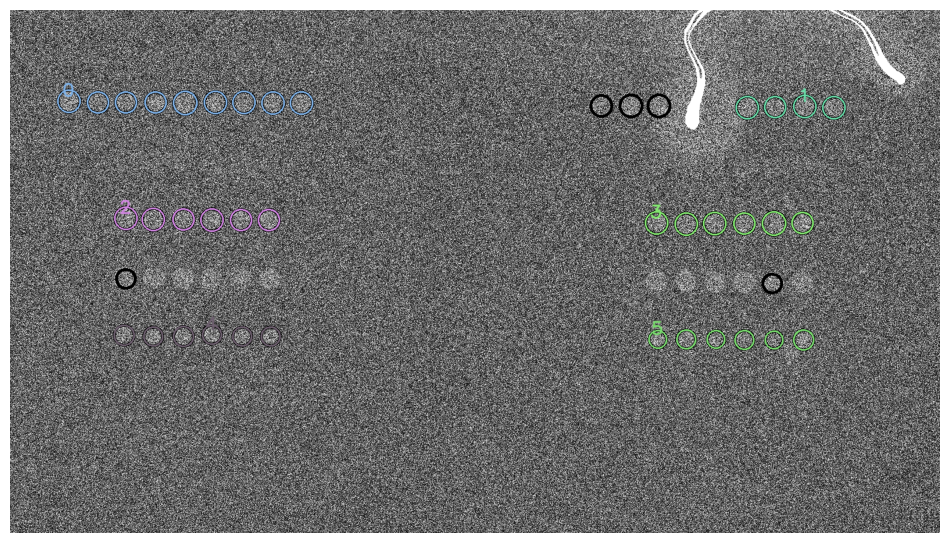

In [81]:
if True:
    test_image = deepcopy(image)[100:1000,1400:3000] #(y,x),
    # test_image = deepcopy(image)[500:1300,160:2600] #(y,x),

    test_sorted_circles = CommonFunctions.circle_detection(
        input_image=test_image,
        detection_params=scan_data.hough_params,
        preprocess_params=scan_data.preprocess_params,
        debug=False,
        plot_images=False
    )
    # CommonFunctions.show_circles_on_plot(test_image, fig_size=[12,12], circles_vec=test_sorted_circles, debug=False)

    test_predicted_clusters_ids = CommonFunctions.DBSCAN_clustering(
        sorted_circles=test_sorted_circles,
        input_image=test_image,
        params=scan_data.DBSCAN_params,
        plot_images=True,
        debug=False,
        debug_clusters_ids=[],
        fig_size=[12,12]
        )

[edit_block          (1236) - restore_backup      (291)]: ** running restore_backup for blockr0c0 with restore_original_clusters_too=True
[edit_block          (1236) - restore_backup      (296)]: starting clusters_ids_list: [0, 3, 7, 169], start_x=405, start_y=72, dont_touch_this_block=False
[edit_block          (1236) - restore_backup      (319)]: No need to restore the start x,y because it matches to backup: (405, 72)
[edit_block          (1236) - restore_backup      (328)]: restoring from ORIGINAL backup for cluster0
[restore_backup      (329) - restore_cluster_from(409)]: Restoring cluster 0 from backup_clusters_dict
[restore_backup      (329) - restore_cluster_from(412)]: this is the restored version: 

	cluster_id: 0	spots_coords_list: total spots=9, spot0=[585, 252, 19]
	spots_coords_in_block_list: total spots=9, spot0=[180 180  19]
	avg_x: 784.8888888888889	avg_y: 254.44444444444446	avg_x_in_block: 379	avg_y_in_block: 182	avg_r: 19.11111111111111	block_id: r0c0	block_start_x: 4

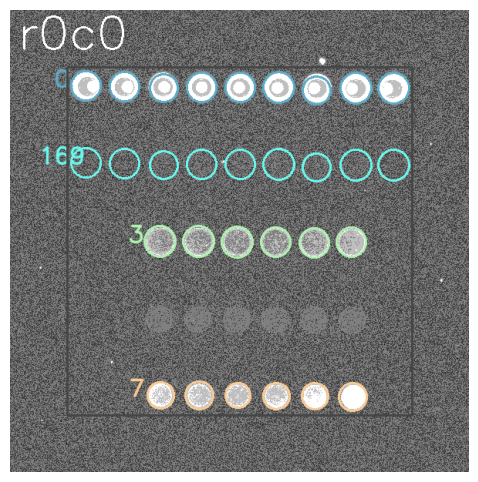

There are 4 clusters in total.


In [84]:
## Making the first template of cluster patterns
start_over=1
if start_over:
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    test_ind = f'r0c0'
    test_block: BlockObj.Block = scan_data.get_block(test_ind)
    manual_spot_edit_dict = {
        # 0:['change_r spot-3 r-2','change_r spot2 r-1','change_r spot0 r-1','move spot-3 3 d, 1 l','move spot2 1 r, 1 d',
        #    'add 1 cluster below d=100'],
        # 5:['change_r all r-2'], 150:['change_r all r+1']
    }
    test_block.edit_block(debug=1, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=False, plot_images=False)
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=True)
    N = len(test_block.clusters_ids_list)
    print(f'There are {N} clusters in total.')
    # print(test_block.full_report(1))


In [ ]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))

In [ ]:
# print(scan_data.get_block('r0c1').full_report(1))

In [ ]:
# print(scan_data.get_cluster(2).full_report(1))
# scan_data.get_cluster(2).spots_coords_in_block_list

In [ ]:
# print(scan_data.get_cluster(2).full_report(1))
#
# scan_data.get_cluster(2).spots_coords_in_block_list

In [ ]:
# row 0
r = 0
plot_results = False if start_over else True
current_list = rows_names_list[r]
fig_size = [12,12] if scan_data.assay == 'SD4' else [15,15]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={'r0c1':[20,0],'r0c2':[-20,0],'r0c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c2'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            11:['del'], 7:['del spot-1',], 10:['del spot0']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

# print(scan_data.get_block('r0c1').full_report(1))

In [ ]:
scan_data.avg_spot_r

In [ ]:
;## row 1
r = 1
current_list = rows_names_list[r]

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        move_whole_block_match={'r1c0':[0,0],'r1c1':[-20,0],'r1c2':[140,123]},
        manual_spot_edit_dict={
            152:['change_r all r+2'], 157:['change_r spot-3 r-3'], 17:['del spot-1']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        move_whole_block_match={'r2c0':[0,0],'r2c1':[10,0],'r2c2':[90,30],'r2c3':[-30,-194]},
        manual_spot_edit_dict={
            9:['del'], 18:['del']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)

In [ ]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        move_whole_block_match={'r3c0':[20,0],'r3c1':[20,200],'r3c2':[0,-100]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 4
r = 4
start_over = 1
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r4c0':[0,0],'r4c1':[0,0],'r4c2':[0,0],'r4c3':[50,0]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r5c0':[0,0],'r5c1':[0,0], 'r5c2':[0,-100]},
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r6c1':[20,20],'r6c2':[100,0]},
        manual_spot_edit_dict={
            # 95:['del'],96:['del'], 94:['del'],99:['del']
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

if start_over:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        # move_whole_block_match={'r7c0':[0,-100], 'r7c1':[0,0],'r7c2':[0,0], },
        manual_spot_edit_dict={
        }
    )

elif plot_results:
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 8
if scan_data.block_nrow > 8:
    r = 8
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
            debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
            preprocess_params=scan_data.preprocess_params, plot_before_after=0,
            move_whole_block_match={'r8c0':[0,100], 'r8c2':[0,0],},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 9
if scan_data.block_nrow > 8:
    r = 9
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=preprocess_params,
            move_whole_block_match={'r9c3':[0,100]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 10
if scan_data.block_nrow > 8:
    r = 10
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=scan_data.preprocess_params,
            manual_spot_edit_dict={
                # 139:['change_r all r+1','move spot0 3 l, 6 d']
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)



In [ ]:
##### row 11
if scan_data.block_nrow > 8:
    r = 11
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=preprocess_params,
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 12
if scan_data.block_nrow > 8:
    r = 12
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=preprocess_params,
            # move_whole_block_match={'r12c2': [0, 30]},
            manual_spot_edit_dict={
            }
        )

    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
##### row 13
if scan_data.block_nrow > 8:
    r = 13
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=preprocess_params,
            # move_whole_block_match={'r13c1': [0, 0], 'r13c2': [0, 20],},
            manual_spot_edit_dict={
            }
        )
    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
    ##### row 14
if scan_data.block_nrow > 8:
        r = 14
        current_list = rows_names_list[r]
        print(current_list)

        if start_over:
            ClassesFunctions.edit_multiple_blocks(
                current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N, fig_size=fig_size,
                debug=0, debug_blocks=[''], plot_before_after=0, preprocess_params=preprocess_params,
                move_whole_block_match={'r14c3':[50,0]},
                manual_spot_edit_dict={
                }
            )

        elif plot_results:
            ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
# scan_data.get_block('r15c0').update_block_start_end_from_clusters_min_max()

In [ ]:
##### row 15
if scan_data.block_nrow > 8:
    r = 15
    current_list = rows_names_list[r]
    print(current_list)

    if start_over:
        ClassesFunctions.edit_multiple_blocks(
            current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,fig_size=fig_size,
            debug=False, debug_blocks=[''], plot_before_after=0, preprocess_params=preprocess_params,
            manual_spot_edit_dict={
            }
        )


    elif plot_results:
        ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list)


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path_no_name)


In [ ]:
scan_data.cAb_names = ['anti_cy5', 'cAb10', 'cAb28', 'cAb9']
scan_data.cAb_names

In [ ]:
## Additional test info and labeling
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
test_info = {'Ag': 'Omicron', 'dAb': 'dAb34'}

if scan_data.assay =='OF':
    curve_num_points = 8
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 3
    num_blank_rows_at_bottom = 1
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2']
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = False
else:
    curve_num_points = 16
    start_Ag_conc = 250
    dilution_factor = 2
    num_rep = 4
    num_blank_rows_at_bottom = 2
    test_info['start_blocks'] = ['r0c0','r0c1','r0c2','r0c3']
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
    weird_dilution = True

def add_labels(info_dict,debug=False, SD4_weird_dilution=False):
    for start_block_id in info_dict['start_blocks']:
        start_block = scan_data.get_block(start_block_id)
        start_block.dAb_label = info_dict['dAb']
        start_block.target = info_dict['Ag']
        start_block.Ag_conc = start_Ag_conc
        start_block.add_names_to_clusters(debug=debug)
        CommonFunctions.debug_report(f'{start_block_id}',debug)
        for n in range(1,curve_num_points):
            new_r = start_block.row_number + n
            new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
            new_block.dAb_label = info_dict['dAb']
            new_block.target = info_dict['Ag']
            if not SD4_weird_dilution:
                new_block.Ag_conc = start_Ag_conc/dilution_factor**(n) if new_r not in blank_rows else 0
            else:
                if new_block.row_number % 2 == 0:
                    new_block.Ag_conc = start_Ag_conc/dilution_factor**(int(n/2)) if new_r not in blank_rows else 0
                elif new_block.row_number % 2 == 1:
                    new_block.Ag_conc = (start_Ag_conc*0.75)/dilution_factor**(int((n-1)/2)) if new_r not in blank_rows else 0
            new_block.add_names_to_clusters(debug=debug)
            CommonFunctions.debug_report(f'r{new_r}c{start_block.col_number}',debug)
add_labels(info_dict=test_info, debug=0, SD4_weird_dilution=weird_dilution)
# ClassesFunctions.save_dicts_in_pickle(path=path)xx/

In [ ]:
scan_data.get_block('r2c0').Ag_conc

In [ ]:
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [ ]:
out_dfs = []
sigma1 = 1.5
sigma2 = 2

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



In [ ]:
# wanna see everything for Z in rXcY:
cAb = 'anti_cy5'
row_id = 7
block_id = f'r{row_id}c0'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='cAb:intensities', crop_to_mask=1)
# print(df)
df

In [ ]:
# formated_path

In [ ]:
dosave=True
formated_path = path_no_name + input_file_name + '_scan_values'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path_no_name)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

In [ ]:
# to see what has been deleted.....
subset = intensities_df[intensities_df['F_B_PostProcess'].isnull()]

block_cab_pairs = set(zip(subset['Block_ID'], subset['cAb_name']))

filtered_df = intensities_df[
    intensities_df[['Block_ID', 'cAb_name']].apply(tuple, axis=1).isin(block_cab_pairs)
]

print(filtered_df.shape)
filtered_df.head(18)


In [ ]:
grouped = intensities_df.groupby(['Ag_Conc.', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])

if num_rep == 4 and curve_num_points==4:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 and x['Col'] % 2 == 0 else
                                            "1" if x['Row'] % 2 == 1 and x['Col'] % 2 == 0 else
                                            "2" if x['Row'] % 2 == 0 and x['Col'] % 2 == 1 else
                                            "3"), axis=1)
elif num_rep == 3:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 3 == 0 else
                                            "1" if x['Col'] % 3 == 1 else
                                            "2"), axis=1)

elif num_rep == 2:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Row'] % 2 == 0 else "1"), axis=1)

elif num_rep == 1:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}", axis=1)

elif num_rep == 4 and curve_num_points==16:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}_" +
                                           ("0" if x['Col'] % 4 == 0 else
                                            "1" if x['Col'] % 4 == 1 else
                                            "2" if x['Col'] % 4 == 2 else
                                            "3"), axis=1)

grouped[grouped['cAb_name']=='cAb10'].head(10)



In [ ]:
results_df = grouped.pivot_table(index=['target', 'Ag_Conc.'], columns=[ 'dAb_cAb_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by='Ag_Conc.',ascending=False)
print(results_df.shape)
results_df


In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path_no_name)

formated_path = path_no_name + input_file_name + '_summary'
results_writer = pd.ExcelWriter(formated_path + '.xlsx')
results_df.to_excel(results_writer, index=True)
results_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(results_df, file)
